# Classifying cell types with neural networks

In this notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset for Shekhar et al., 2016. These cells have been manually annotated, and here we will show that a neural network can recapitulate these cell type labels.

## 1. Imports

In [1]:
!pip install scprep

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [3]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [4]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [5]:
data = scprep.reduce.pca(data_raw, n_components=50, method='dense').to_numpy()
data

array([[ -2.86639095,  16.11995588,   4.36943184, ...,  -0.11234979,
          1.7299245 ,  -0.51799205],
       [ -0.66863206,  13.21553129,  -4.89263884, ...,   0.60644992,
         -2.22500555,   1.61151165],
       [  0.29665496,   6.85551504,  18.19106804, ...,  -1.29519389,
         -1.83771491,   0.69086508],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.16420667, ...,   3.84276271,
          2.37456759,  -0.88676498],
       [  3.13934964,  15.10619606,   3.69472725, ...,   0.5699963 ,
          2.0070919 ,   1.91574298],
       [ 42.90597659,  -9.79281524, -13.25215016, ...,   1.10410408,
         -0.95482509,  -4.08401425]])

For easier classification, we'll scale the data to have mean 0 and standard deviation 1 across all features.

In [6]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)
data

array([[-0.17060225,  1.43324626,  0.61033178, ..., -0.05054343,
         0.78032613, -0.23421798],
       [-0.03979573,  1.17501009, -0.68341448, ...,  0.27282701,
        -1.00364494,  0.72866948],
       [ 0.01765635,  0.60953277,  2.54096812, ..., -0.5826761 ,
        -0.82894772,  0.31238514],
       ...,
       [ 2.35163964, -0.72986086, -1.41975859, ...,  1.72876509,
         1.07110867, -0.40096426],
       [ 0.18684824,  1.34311156,  0.51608757, ...,  0.25642742,
         0.90534949,  0.8662323 ],
       [ 2.55368378, -0.87069195, -1.85108928, ...,  0.49670946,
        -0.43069797, -1.8466491 ]])

In [7]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

array([ 0,  1,  2, ..., 20, 20, 20])

In [8]:
num_classes = len(np.unique(labels))
num_classes

29

#### Splitting the data into training and validation sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [9]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

((17241, 50), (4311, 50))

## 3. Moving Our Data to PyTorch Tensors 

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available. 

In [10]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [11]:
# check shapes
print("train tensor shape: {}".format(train_tensor.shape))
print("train labels shape: {}".format(train_labels.shape))

print("valid tensor shape: {}".format(valid_tensor.shape))
print("valid labels shape: {}".format(valid_labels.shape))

train tensor shape: torch.Size([17241, 50])
train labels shape: torch.Size([17241])
valid tensor shape: torch.Size([4311, 50])
valid labels shape: torch.Size([4311])


## Exercise 1 - Tensor Operations 1

1. Create a tensor called x of values (0, 1, ..., 18, 19) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [12]:
# create x using torch.arange()
x = torch.arange(20)

# reshape to (4,5)
x = x.reshape(4,5)

# add 5
y = x + 5

# power y to the 3rd power
z = y ** 3

# print the first row of z
print(z[0])

tensor([125, 216, 343, 512, 729])


## Exercise 2 - Tensor Operations 2

1. Subset the training tensor by taking the last 5 rows

2. Double the values and print the result.


In [13]:
# Get the last five rows of `train_tensor`
data_last5 = train_tensor[-5:]

# Multiply by two
last5_double = data_last5 * 2

# Print the result
last5_double

tensor([[-4.2113e-01,  1.2117e+00,  2.1553e+00,  7.8266e-02,  3.1221e+00,
         -3.4544e+00,  2.6318e+00, -9.3449e-01,  1.4304e+00, -5.3987e+00,
          4.0091e+00, -1.2567e+00, -3.1295e-01, -1.2526e+00,  9.3788e-01,
          1.0750e+00,  1.8250e+00, -1.1379e+00,  7.1853e-01, -1.2121e+00,
          9.3699e-01, -4.6135e+00,  5.7402e-01,  3.1311e+00, -2.5260e+00,
          1.4529e-01, -6.7311e-01, -2.4681e+00, -3.7444e+00,  1.4381e-02,
          9.6159e-01, -3.2102e+00, -2.7962e+00,  2.3028e+00,  2.3865e+00,
          1.2495e+00, -2.1763e+00, -1.2292e+00,  1.2269e+00, -3.8964e-01,
          2.0659e+00, -1.0931e+00,  8.6275e-01, -6.5621e-01,  1.7447e+00,
         -1.2584e+00, -1.0111e-01, -2.2925e+00, -1.5418e+00, -2.9327e+00],
        [-5.7734e-01,  2.0474e+00,  7.9776e-01, -1.3401e+00,  5.4539e-01,
         -2.8550e+00,  2.3355e+00,  6.9715e+00, -2.1735e-02, -9.6972e-01,
          6.3356e-01, -3.3495e+00, -2.9552e-02,  2.6458e-01, -2.2313e+00,
          2.5590e+00, -1.9633e+00, -1

## 4. Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [14]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [15]:
input_size = data_training.shape[1]
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output

tensor([[1.9071e-06, 4.5450e-07, 2.0708e-08,  ..., 1.4092e-06, 2.9459e-05,
         1.8565e-07],
        [4.8624e-18, 2.3028e-31, 3.3190e-30,  ..., 2.5563e-44, 1.1024e-30,
         3.6773e-21],
        [3.4560e-13, 1.1139e-16, 6.0736e-19,  ..., 2.6030e-13, 1.4103e-11,
         1.2216e-30],
        ...,
        [1.4414e-07, 5.1117e-12, 4.0701e-11,  ..., 3.2010e-14, 1.7424e-09,
         1.3430e-13],
        [1.3298e-13, 1.5647e-16, 2.7803e-12,  ..., 1.2214e-28, 4.1412e-21,
         1.7462e-17],
        [3.2246e-10, 3.0450e-09, 3.2569e-08,  ..., 1.5323e-20, 1.6100e-17,
         1.8929e-16]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Build the loss function

In order to train our neural network, we need to define a loss function which tells us how well (or how poorly) our classifier performed.

Here, we'll use the cross-entropy loss which we discussed in lecture.

In [16]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [17]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

tensor(310308.3751, dtype=torch.float64, grad_fn=<MulBackward0>)

#### Creating a model with PyTorch

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for PyTorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters to be optimized.

In [19]:
model = nn.Sequential(layer_1, layer_2)
print(model)

Sequential(
  (0): layer(
    (activation): ReLU()
  )
  (1): layer(
    (activation): Softmax(dim=-1)
  )
)


We can now obtain the output of our model by simply calling `model(data)`.

In [20]:
model(train_tensor)

tensor([[1.9071e-06, 4.5450e-07, 2.0708e-08,  ..., 1.4092e-06, 2.9459e-05,
         1.8565e-07],
        [4.8624e-18, 2.3028e-31, 3.3190e-30,  ..., 2.5563e-44, 1.1024e-30,
         3.6773e-21],
        [3.4560e-13, 1.1139e-16, 6.0736e-19,  ..., 2.6030e-13, 1.4103e-11,
         1.2216e-30],
        ...,
        [1.4414e-07, 5.1117e-12, 4.0701e-11,  ..., 3.2010e-14, 1.7424e-09,
         1.3430e-13],
        [1.3298e-13, 1.5647e-16, 2.7803e-12,  ..., 1.2214e-28, 4.1412e-21,
         1.7462e-17],
        [3.2246e-10, 3.0450e-09, 3.2569e-08,  ..., 1.5323e-20, 1.6100e-17,
         1.8929e-16]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Create the optimizer

To update the model parameters, PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [21]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 128

#### Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [22]:
# train the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(100):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 964.066 training accuracy: 0.279 validation accuracy: 0.209 
Step 100 loss: 769.378 training accuracy: 0.391 validation accuracy: 0.222 
Step 150 loss: 490.936 training accuracy: 0.481 validation accuracy: 0.356 
Step 200 loss: 460.595 training accuracy: 0.411 validation accuracy: 0.409 
Step 250 loss: 343.009 training accuracy: 0.578 validation accuracy: 0.504 
Step 300 loss: 325.928 training accuracy: 0.589 validation accuracy: 0.553 
Step 350 loss: 200.225 training accuracy: 0.690 validation accuracy: 0.597 
Step 400 loss: 239.612 training accuracy: 0.727 validation accuracy: 0.638 
Step 450 loss: 153.631 training accuracy: 0.752 validation accuracy: 0.655 
Step 500 loss: 284.717 training accuracy: 0.641 validation accuracy: 0.675 
Step 550 loss: 153.640 training accuracy: 0.798 validation accuracy: 0.696 
Step 600 loss: 130.430 training accuracy: 0.837 validation accuracy: 0.705 
Step 650 loss: 155.260 training accuracy: 0.812 validation accuracy: 0.715 
Step 700 loss

Step 5450 loss: 63.001 training accuracy: 0.906 validation accuracy: 0.867 
Step 5500 loss: 69.905 training accuracy: 0.899 validation accuracy: 0.871 
Step 5550 loss: 52.174 training accuracy: 0.938 validation accuracy: 0.870 
Step 5600 loss: 52.804 training accuracy: 0.914 validation accuracy: 0.864 
Step 5650 loss: 96.017 training accuracy: 0.884 validation accuracy: 0.869 
Step 5700 loss: 76.548 training accuracy: 0.891 validation accuracy: 0.865 
Step 5750 loss: 88.629 training accuracy: 0.875 validation accuracy: 0.866 
Step 5800 loss: 39.325 training accuracy: 0.938 validation accuracy: 0.867 
Step 5850 loss: 56.482 training accuracy: 0.915 validation accuracy: 0.871 
Step 5900 loss: 75.494 training accuracy: 0.891 validation accuracy: 0.867 
Step 5950 loss: 67.515 training accuracy: 0.891 validation accuracy: 0.870 
Step 6000 loss: 51.437 training accuracy: 0.898 validation accuracy: 0.865 
Step 6050 loss: 58.034 training accuracy: 0.938 validation accuracy: 0.864 
Step 6100 lo

Step 10850 loss: 37.779 training accuracy: 0.961 validation accuracy: 0.879 
Step 10900 loss: 59.620 training accuracy: 0.884 validation accuracy: 0.878 
Step 10950 loss: 67.732 training accuracy: 0.930 validation accuracy: 0.878 
Step 11000 loss: 51.783 training accuracy: 0.922 validation accuracy: 0.873 
Step 11050 loss: 70.323 training accuracy: 0.860 validation accuracy: 0.872 
Step 11100 loss: 57.503 training accuracy: 0.930 validation accuracy: 0.875 
Step 11150 loss: 59.469 training accuracy: 0.876 validation accuracy: 0.875 
Step 11200 loss: 55.980 training accuracy: 0.938 validation accuracy: 0.876 
Step 11250 loss: 58.619 training accuracy: 0.914 validation accuracy: 0.875 
Step 11300 loss: 61.455 training accuracy: 0.891 validation accuracy: 0.873 
Step 11350 loss: 75.228 training accuracy: 0.828 validation accuracy: 0.875 
Step 11400 loss: 44.735 training accuracy: 0.930 validation accuracy: 0.876 
Step 11450 loss: 76.385 training accuracy: 0.884 validation accuracy: 0.881 

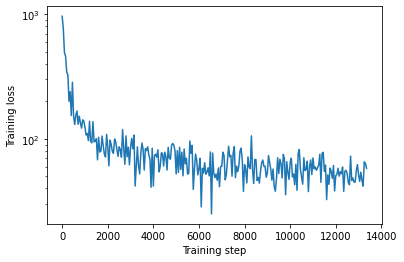

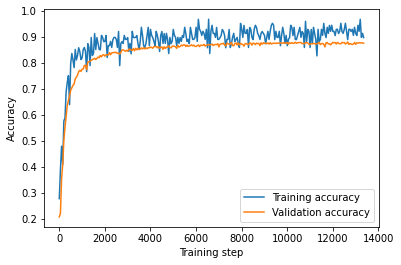

In [23]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did our network do? Is the classification accuracy high? 
    - The classification accuracy is pretty good -- it got to about 85%.
2. How many iterations did it take for the training accuracy to stop increasing?
    - The training accuracy converged after around 6,000 steps.
3. How many iterations did it take for the training loss to stop decreasing?
    - The training accuracy converged after around 10,000 steps.
4. How many iterations did it take for the validation accuracy to stop increasing?
    - The validation accuracy converged after around 3,000 steps.

## Exercise 3 - network width

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built.

In [24]:
# let's set some hyperparameters
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider hidden layer
num_hidden = 100
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2)

# create the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 3040.192 training accuracy: 0.008 validation accuracy: 0.017 
Step 100 loss: 2983.542 training accuracy: 0.031 validation accuracy: 0.047 
Step 150 loss: 2080.256 training accuracy: 0.357 validation accuracy: 0.250 
Step 200 loss: 1431.857 training accuracy: 0.496 validation accuracy: 0.357 
Step 250 loss: 1410.456 training accuracy: 0.539 validation accuracy: 0.392 
Step 300 loss: 1243.185 training accuracy: 0.597 validation accuracy: 0.441 
Step 350 loss: 1262.331 training accuracy: 0.581 validation accuracy: 0.482 
Step 400 loss: 1210.603 training accuracy: 0.609 validation accuracy: 0.493 
Step 450 loss: 1156.422 training accuracy: 0.628 validation accuracy: 0.519 
Step 500 loss: 1085.962 training accuracy: 0.633 validation accuracy: 0.520 
Step 550 loss: 1114.245 training accuracy: 0.628 validation accuracy: 0.514 
Step 600 loss: 1232.610 training accuracy: 0.605 validation accuracy: 0.522 
Step 650 loss: 1137.987 training accuracy: 0.633 validation accuracy: 0.520 


Step 5550 loss: 387.757 training accuracy: 0.829 validation accuracy: 0.747 
Step 5600 loss: 381.881 training accuracy: 0.844 validation accuracy: 0.746 
Step 5650 loss: 253.273 training accuracy: 0.891 validation accuracy: 0.745 
Step 5700 loss: 199.442 training accuracy: 0.907 validation accuracy: 0.746 
Step 5750 loss: 275.021 training accuracy: 0.883 validation accuracy: 0.747 
Step 5800 loss: 311.676 training accuracy: 0.860 validation accuracy: 0.747 
Step 5850 loss: 299.511 training accuracy: 0.868 validation accuracy: 0.747 
Step 5900 loss: 412.142 training accuracy: 0.814 validation accuracy: 0.741 
Step 5950 loss: 271.913 training accuracy: 0.884 validation accuracy: 0.742 
Step 6000 loss: 218.600 training accuracy: 0.883 validation accuracy: 0.744 
Step 6050 loss: 330.486 training accuracy: 0.868 validation accuracy: 0.746 
Step 6100 loss: 405.172 training accuracy: 0.822 validation accuracy: 0.745 
Step 6150 loss: 285.964 training accuracy: 0.875 validation accuracy: 0.743 

Step 11050 loss: 308.840 training accuracy: 0.860 validation accuracy: 0.749 
Step 11100 loss: 261.066 training accuracy: 0.883 validation accuracy: 0.749 
Step 11150 loss: 291.764 training accuracy: 0.876 validation accuracy: 0.751 
Step 11200 loss: 291.274 training accuracy: 0.868 validation accuracy: 0.748 
Step 11250 loss: 250.081 training accuracy: 0.891 validation accuracy: 0.749 
Step 11300 loss: 323.679 training accuracy: 0.837 validation accuracy: 0.749 
Step 11350 loss: 290.975 training accuracy: 0.859 validation accuracy: 0.749 
Step 11400 loss: 340.229 training accuracy: 0.845 validation accuracy: 0.749 
Step 11450 loss: 267.538 training accuracy: 0.884 validation accuracy: 0.749 
Step 11500 loss: 222.809 training accuracy: 0.891 validation accuracy: 0.750 
Step 11550 loss: 291.062 training accuracy: 0.860 validation accuracy: 0.748 
Step 11600 loss: 106.511 training accuracy: 0.953 validation accuracy: 0.749 
Step 11650 loss: 285.970 training accuracy: 0.875 validation acc

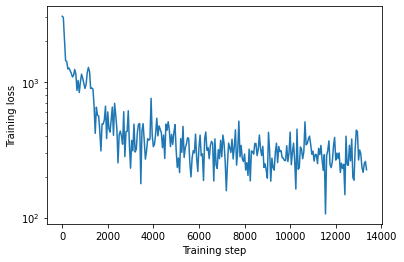

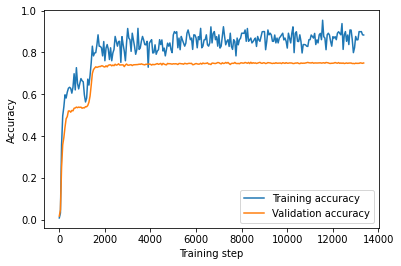

In [25]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - optimizers

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [26]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2)

# =========
# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)
# =========

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2447.832 training accuracy: 0.039 validation accuracy: 0.040 
Step 100 loss: 2319.852 training accuracy: 0.070 validation accuracy: 0.047 
Step 150 loss: 2462.336 training accuracy: 0.047 validation accuracy: 0.057 
Step 200 loss: 2266.029 training accuracy: 0.085 validation accuracy: 0.068 
Step 250 loss: 2071.416 training accuracy: 0.125 validation accuracy: 0.081 
Step 300 loss: 1969.731 training accuracy: 0.155 validation accuracy: 0.091 
Step 350 loss: 2123.282 training accuracy: 0.132 validation accuracy: 0.105 
Step 400 loss: 1883.614 training accuracy: 0.211 validation accuracy: 0.115 
Step 450 loss: 1589.092 training accuracy: 0.240 validation accuracy: 0.130 
Step 500 loss: 1683.156 training accuracy: 0.219 validation accuracy: 0.146 
Step 550 loss: 1706.693 training accuracy: 0.256 validation accuracy: 0.159 
Step 600 loss: 1702.813 training accuracy: 0.233 validation accuracy: 0.172 
Step 650 loss: 1541.199 training accuracy: 0.305 validation accuracy: 0.186 


Step 5550 loss: 145.600 training accuracy: 0.876 validation accuracy: 0.780 
Step 5600 loss: 216.287 training accuracy: 0.805 validation accuracy: 0.782 
Step 5650 loss: 141.907 training accuracy: 0.860 validation accuracy: 0.783 
Step 5700 loss: 131.996 training accuracy: 0.891 validation accuracy: 0.784 
Step 5750 loss: 200.760 training accuracy: 0.844 validation accuracy: 0.782 
Step 5800 loss: 197.492 training accuracy: 0.829 validation accuracy: 0.781 
Step 5850 loss: 157.980 training accuracy: 0.884 validation accuracy: 0.784 
Step 5900 loss: 112.864 training accuracy: 0.853 validation accuracy: 0.785 
Step 5950 loss: 138.559 training accuracy: 0.829 validation accuracy: 0.787 
Step 6000 loss: 121.573 training accuracy: 0.891 validation accuracy: 0.791 
Step 6050 loss: 128.110 training accuracy: 0.860 validation accuracy: 0.795 
Step 6100 loss: 101.387 training accuracy: 0.891 validation accuracy: 0.798 
Step 6150 loss: 111.857 training accuracy: 0.852 validation accuracy: 0.799 

Step 11050 loss: 71.079 training accuracy: 0.922 validation accuracy: 0.868 
Step 11100 loss: 35.865 training accuracy: 0.961 validation accuracy: 0.867 
Step 11150 loss: 56.210 training accuracy: 0.915 validation accuracy: 0.868 
Step 11200 loss: 64.178 training accuracy: 0.938 validation accuracy: 0.868 
Step 11250 loss: 60.332 training accuracy: 0.906 validation accuracy: 0.870 
Step 11300 loss: 58.278 training accuracy: 0.899 validation accuracy: 0.870 
Step 11350 loss: 58.888 training accuracy: 0.922 validation accuracy: 0.868 
Step 11400 loss: 43.391 training accuracy: 0.922 validation accuracy: 0.870 
Step 11450 loss: 69.547 training accuracy: 0.915 validation accuracy: 0.869 
Step 11500 loss: 60.825 training accuracy: 0.922 validation accuracy: 0.870 
Step 11550 loss: 56.506 training accuracy: 0.922 validation accuracy: 0.868 
Step 11600 loss: 75.966 training accuracy: 0.891 validation accuracy: 0.871 
Step 11650 loss: 101.417 training accuracy: 0.867 validation accuracy: 0.870

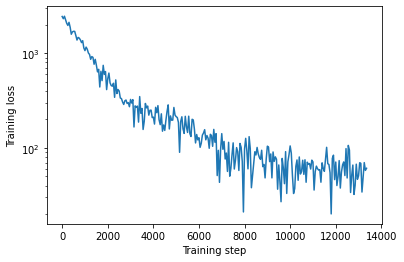

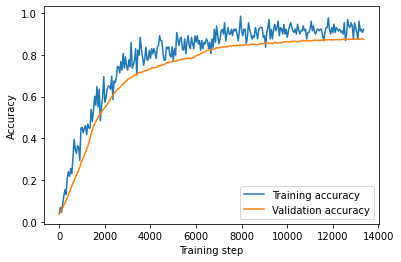

In [27]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - network depth

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built. Try increasing the number of epochs if the loss hasn't stopped increasing.

In [28]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
# ========
# Create an additional hidden layer
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
# ========
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2661.907 training accuracy: 0.124 validation accuracy: 0.161 
Step 100 loss: 2275.103 training accuracy: 0.258 validation accuracy: 0.181 
Step 150 loss: 2166.160 training accuracy: 0.287 validation accuracy: 0.196 
Step 200 loss: 2144.097 training accuracy: 0.279 validation accuracy: 0.209 
Step 250 loss: 1945.386 training accuracy: 0.352 validation accuracy: 0.220 
Step 300 loss: 2063.291 training accuracy: 0.295 validation accuracy: 0.230 
Step 350 loss: 1882.018 training accuracy: 0.403 validation accuracy: 0.240 
Step 400 loss: 1906.175 training accuracy: 0.367 validation accuracy: 0.251 
Step 450 loss: 1801.801 training accuracy: 0.411 validation accuracy: 0.256 
Step 500 loss: 1996.446 training accuracy: 0.312 validation accuracy: 0.263 
Step 550 loss: 1604.245 training accuracy: 0.411 validation accuracy: 0.269 
Step 600 loss: 1883.478 training accuracy: 0.341 validation accuracy: 0.271 
Step 650 loss: 1461.864 training accuracy: 0.445 validation accuracy: 0.276 


Step 5550 loss: 553.214 training accuracy: 0.651 validation accuracy: 0.612 
Step 5600 loss: 474.969 training accuracy: 0.680 validation accuracy: 0.612 
Step 5650 loss: 458.652 training accuracy: 0.744 validation accuracy: 0.612 
Step 5700 loss: 343.889 training accuracy: 0.783 validation accuracy: 0.612 
Step 5750 loss: 588.279 training accuracy: 0.625 validation accuracy: 0.616 
Step 5800 loss: 507.447 training accuracy: 0.690 validation accuracy: 0.615 
Step 5850 loss: 550.797 training accuracy: 0.674 validation accuracy: 0.617 
Step 5900 loss: 415.930 training accuracy: 0.767 validation accuracy: 0.622 
Step 5950 loss: 533.021 training accuracy: 0.721 validation accuracy: 0.621 
Step 6000 loss: 412.525 training accuracy: 0.719 validation accuracy: 0.621 
Step 6050 loss: 475.194 training accuracy: 0.736 validation accuracy: 0.623 
Step 6100 loss: 384.699 training accuracy: 0.744 validation accuracy: 0.624 
Step 6150 loss: 350.315 training accuracy: 0.797 validation accuracy: 0.632 

Step 11050 loss: 186.162 training accuracy: 0.891 validation accuracy: 0.783 
Step 11100 loss: 142.167 training accuracy: 0.867 validation accuracy: 0.786 
Step 11150 loss: 199.156 training accuracy: 0.853 validation accuracy: 0.788 
Step 11200 loss: 139.184 training accuracy: 0.884 validation accuracy: 0.785 
Step 11250 loss: 156.790 training accuracy: 0.852 validation accuracy: 0.785 
Step 11300 loss: 92.003 training accuracy: 0.930 validation accuracy: 0.788 
Step 11350 loss: 203.185 training accuracy: 0.812 validation accuracy: 0.786 
Step 11400 loss: 193.279 training accuracy: 0.853 validation accuracy: 0.788 
Step 11450 loss: 155.589 training accuracy: 0.860 validation accuracy: 0.789 
Step 11500 loss: 132.316 training accuracy: 0.875 validation accuracy: 0.788 
Step 11550 loss: 125.092 training accuracy: 0.876 validation accuracy: 0.789 
Step 11600 loss: 239.781 training accuracy: 0.829 validation accuracy: 0.791 
Step 11650 loss: 216.825 training accuracy: 0.836 validation accu

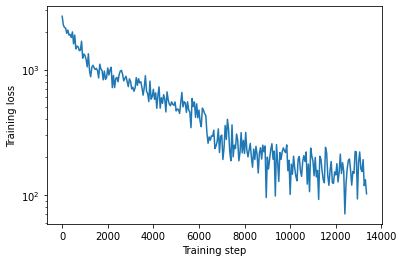

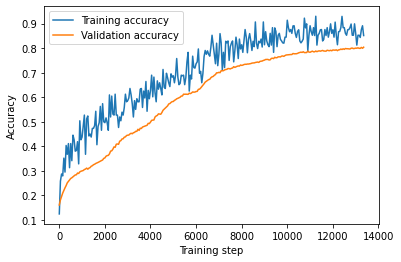

In [29]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 5 - activation functions

PyTorch provides a number of different activations for us to choose from. Replace `nn.ReLU` with any of `nn.Tanh`, `nn.Sigmoid` and `nn.LeakyReLU` or any others you find in the PyTorch docs to build the best possible network.

In [30]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 3063.814 training accuracy: 0.000 validation accuracy: 0.009 
Step 100 loss: 2959.228 training accuracy: 0.008 validation accuracy: 0.009 
Step 150 loss: 2979.571 training accuracy: 0.016 validation accuracy: 0.010 
Step 200 loss: 2975.376 training accuracy: 0.016 validation accuracy: 0.012 
Step 250 loss: 2778.954 training accuracy: 0.039 validation accuracy: 0.014 
Step 300 loss: 2775.854 training accuracy: 0.023 validation accuracy: 0.020 
Step 350 loss: 2569.299 training accuracy: 0.070 validation accuracy: 0.032 
Step 400 loss: 2461.542 training accuracy: 0.117 validation accuracy: 0.057 
Step 450 loss: 2123.561 training accuracy: 0.233 validation accuracy: 0.091 
Step 500 loss: 2134.295 training accuracy: 0.227 validation accuracy: 0.121 
Step 550 loss: 2158.347 training accuracy: 0.240 validation accuracy: 0.141 
Step 600 loss: 2043.625 training accuracy: 0.287 validation accuracy: 0.155 
Step 650 loss: 1892.931 training accuracy: 0.297 validation accuracy: 0.162 


Step 5500 loss: 293.529 training accuracy: 0.698 validation accuracy: 0.635 
Step 5550 loss: 220.296 training accuracy: 0.721 validation accuracy: 0.634 
Step 5600 loss: 214.256 training accuracy: 0.766 validation accuracy: 0.639 
Step 5650 loss: 222.196 training accuracy: 0.760 validation accuracy: 0.640 
Step 5700 loss: 261.385 training accuracy: 0.744 validation accuracy: 0.645 
Step 5750 loss: 210.983 training accuracy: 0.719 validation accuracy: 0.647 
Step 5800 loss: 269.685 training accuracy: 0.698 validation accuracy: 0.652 
Step 5850 loss: 336.445 training accuracy: 0.713 validation accuracy: 0.650 
Step 5900 loss: 292.579 training accuracy: 0.705 validation accuracy: 0.652 
Step 5950 loss: 227.493 training accuracy: 0.767 validation accuracy: 0.659 
Step 6000 loss: 308.209 training accuracy: 0.688 validation accuracy: 0.657 
Step 6050 loss: 246.177 training accuracy: 0.705 validation accuracy: 0.660 
Step 6100 loss: 185.127 training accuracy: 0.760 validation accuracy: 0.663 

Step 11000 loss: 76.629 training accuracy: 0.891 validation accuracy: 0.831 
Step 11050 loss: 41.404 training accuracy: 0.930 validation accuracy: 0.829 
Step 11100 loss: 105.301 training accuracy: 0.891 validation accuracy: 0.829 
Step 11150 loss: 89.153 training accuracy: 0.876 validation accuracy: 0.831 
Step 11200 loss: 83.694 training accuracy: 0.868 validation accuracy: 0.831 
Step 11250 loss: 61.782 training accuracy: 0.914 validation accuracy: 0.829 
Step 11300 loss: 99.473 training accuracy: 0.876 validation accuracy: 0.830 
Step 11350 loss: 73.544 training accuracy: 0.898 validation accuracy: 0.831 
Step 11400 loss: 62.102 training accuracy: 0.915 validation accuracy: 0.833 
Step 11450 loss: 68.314 training accuracy: 0.899 validation accuracy: 0.831 
Step 11500 loss: 84.183 training accuracy: 0.906 validation accuracy: 0.832 
Step 11550 loss: 72.396 training accuracy: 0.899 validation accuracy: 0.832 
Step 11600 loss: 89.794 training accuracy: 0.899 validation accuracy: 0.830

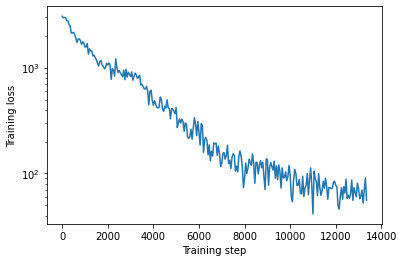

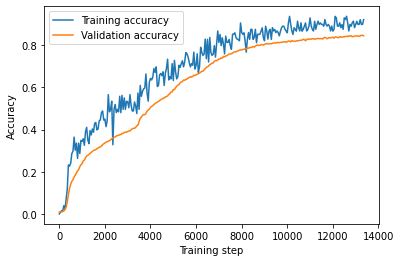

In [31]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 6 - more network depth

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [32]:
# ======
# Create a five-layer network based on the code in the exercise above
# let's set some hyperparameters
batch_size = 128
# ========
# as you add further additional layers, you may wish to decrease the learning rate, e.g. to 0.0001
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.0001
n_epochs = 500
# ========
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())

# Create additional hidden layers
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_4 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_5 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 3530.636 training accuracy: 0.000 validation accuracy: 0.005 
Step 100 loss: 3515.129 training accuracy: 0.000 validation accuracy: 0.005 
Step 150 loss: 3564.369 training accuracy: 0.000 validation accuracy: 0.005 
Step 200 loss: 3543.297 training accuracy: 0.000 validation accuracy: 0.005 
Step 250 loss: 3535.836 training accuracy: 0.000 validation accuracy: 0.005 
Step 300 loss: 3519.010 training accuracy: 0.008 validation accuracy: 0.005 
Step 350 loss: 3473.129 training accuracy: 0.008 validation accuracy: 0.005 
Step 400 loss: 3536.767 training accuracy: 0.000 validation accuracy: 0.005 
Step 450 loss: 3552.156 training accuracy: 0.000 validation accuracy: 0.005 
Step 500 loss: 3521.167 training accuracy: 0.000 validation accuracy: 0.005 
Step 550 loss: 3563.543 training accuracy: 0.000 validation accuracy: 0.005 
Step 600 loss: 3552.080 training accuracy: 0.000 validation accuracy: 0.005 
Step 650 loss: 3498.512 training accuracy: 0.008 validation accuracy: 0.005 


Step 5450 loss: 3511.122 training accuracy: 0.000 validation accuracy: 0.005 
Step 5500 loss: 3476.326 training accuracy: 0.016 validation accuracy: 0.005 
Step 5550 loss: 3527.657 training accuracy: 0.000 validation accuracy: 0.005 
Step 5600 loss: 3512.041 training accuracy: 0.000 validation accuracy: 0.005 
Step 5650 loss: 3492.309 training accuracy: 0.008 validation accuracy: 0.005 
Step 5700 loss: 3485.232 training accuracy: 0.008 validation accuracy: 0.005 
Step 5750 loss: 3499.082 training accuracy: 0.000 validation accuracy: 0.005 
Step 5800 loss: 3521.351 training accuracy: 0.000 validation accuracy: 0.005 
Step 5850 loss: 3532.225 training accuracy: 0.000 validation accuracy: 0.005 
Step 5900 loss: 3502.802 training accuracy: 0.008 validation accuracy: 0.005 
Step 5950 loss: 3538.677 training accuracy: 0.000 validation accuracy: 0.005 
Step 6000 loss: 3482.291 training accuracy: 0.000 validation accuracy: 0.005 
Step 6050 loss: 3450.674 training accuracy: 0.008 validation acc

Step 10700 loss: 3486.243 training accuracy: 0.000 validation accuracy: 0.005 
Step 10750 loss: 3516.479 training accuracy: 0.000 validation accuracy: 0.005 
Step 10800 loss: 3526.732 training accuracy: 0.000 validation accuracy: 0.005 
Step 10850 loss: 3497.745 training accuracy: 0.000 validation accuracy: 0.005 
Step 10900 loss: 3564.398 training accuracy: 0.000 validation accuracy: 0.005 
Step 10950 loss: 3505.067 training accuracy: 0.000 validation accuracy: 0.005 
Step 11000 loss: 3460.554 training accuracy: 0.008 validation accuracy: 0.005 
Step 11050 loss: 3524.328 training accuracy: 0.008 validation accuracy: 0.005 
Step 11100 loss: 3436.935 training accuracy: 0.008 validation accuracy: 0.005 
Step 11150 loss: 3502.656 training accuracy: 0.000 validation accuracy: 0.005 
Step 11200 loss: 3543.172 training accuracy: 0.000 validation accuracy: 0.005 
Step 11250 loss: 3463.404 training accuracy: 0.000 validation accuracy: 0.005 
Step 11300 loss: 3523.165 training accuracy: 0.000 v

Step 15950 loss: 3542.098 training accuracy: 0.000 validation accuracy: 0.005 
Step 16000 loss: 3540.191 training accuracy: 0.000 validation accuracy: 0.005 
Step 16050 loss: 3512.966 training accuracy: 0.000 validation accuracy: 0.005 
Step 16100 loss: 3514.753 training accuracy: 0.000 validation accuracy: 0.005 
Step 16150 loss: 3519.412 training accuracy: 0.000 validation accuracy: 0.005 
Step 16200 loss: 3423.804 training accuracy: 0.008 validation accuracy: 0.005 
Step 16250 loss: 3484.736 training accuracy: 0.000 validation accuracy: 0.005 
Step 16300 loss: 3495.623 training accuracy: 0.000 validation accuracy: 0.005 
Step 16350 loss: 3481.045 training accuracy: 0.008 validation accuracy: 0.005 
Step 16400 loss: 3545.169 training accuracy: 0.000 validation accuracy: 0.005 
Step 16450 loss: 3443.379 training accuracy: 0.000 validation accuracy: 0.005 
Step 16500 loss: 3519.893 training accuracy: 0.000 validation accuracy: 0.005 
Step 16550 loss: 3516.535 training accuracy: 0.000 v

Step 21200 loss: 3525.250 training accuracy: 0.000 validation accuracy: 0.005 
Step 21250 loss: 3505.293 training accuracy: 0.000 validation accuracy: 0.005 
Step 21300 loss: 3488.188 training accuracy: 0.000 validation accuracy: 0.005 
Step 21350 loss: 3489.536 training accuracy: 0.000 validation accuracy: 0.005 
Step 21400 loss: 3458.293 training accuracy: 0.000 validation accuracy: 0.005 
Step 21450 loss: 3502.562 training accuracy: 0.016 validation accuracy: 0.005 
Step 21500 loss: 3450.226 training accuracy: 0.016 validation accuracy: 0.005 
Step 21550 loss: 3444.577 training accuracy: 0.008 validation accuracy: 0.005 
Step 21600 loss: 3539.873 training accuracy: 0.000 validation accuracy: 0.005 
Step 21650 loss: 3521.514 training accuracy: 0.000 validation accuracy: 0.005 
Step 21700 loss: 3435.391 training accuracy: 0.008 validation accuracy: 0.005 
Step 21750 loss: 3449.211 training accuracy: 0.000 validation accuracy: 0.005 
Step 21800 loss: 3431.763 training accuracy: 0.000 v

Step 26450 loss: 3423.250 training accuracy: 0.016 validation accuracy: 0.005 
Step 26500 loss: 3489.230 training accuracy: 0.000 validation accuracy: 0.005 
Step 26550 loss: 3511.422 training accuracy: 0.000 validation accuracy: 0.005 
Step 26600 loss: 3452.655 training accuracy: 0.008 validation accuracy: 0.005 
Step 26650 loss: 3438.209 training accuracy: 0.008 validation accuracy: 0.005 
Step 26700 loss: 3478.006 training accuracy: 0.016 validation accuracy: 0.005 
Step 26750 loss: 3508.354 training accuracy: 0.000 validation accuracy: 0.005 
Step 26800 loss: 3444.426 training accuracy: 0.000 validation accuracy: 0.005 
Step 26850 loss: 3493.842 training accuracy: 0.000 validation accuracy: 0.005 
Step 26900 loss: 3423.047 training accuracy: 0.008 validation accuracy: 0.005 
Step 26950 loss: 3482.968 training accuracy: 0.000 validation accuracy: 0.005 
Step 27000 loss: 3518.686 training accuracy: 0.000 validation accuracy: 0.005 
Step 27050 loss: 3447.411 training accuracy: 0.008 v

Step 31700 loss: 3508.095 training accuracy: 0.008 validation accuracy: 0.005 
Step 31750 loss: 3463.860 training accuracy: 0.000 validation accuracy: 0.005 
Step 31800 loss: 3507.257 training accuracy: 0.000 validation accuracy: 0.005 
Step 31850 loss: 3387.719 training accuracy: 0.016 validation accuracy: 0.005 
Step 31900 loss: 3494.056 training accuracy: 0.000 validation accuracy: 0.005 
Step 31950 loss: 3482.280 training accuracy: 0.008 validation accuracy: 0.005 
Step 32000 loss: 3454.686 training accuracy: 0.000 validation accuracy: 0.005 
Step 32050 loss: 3483.522 training accuracy: 0.016 validation accuracy: 0.005 
Step 32100 loss: 3462.516 training accuracy: 0.016 validation accuracy: 0.005 
Step 32150 loss: 3452.471 training accuracy: 0.000 validation accuracy: 0.005 
Step 32200 loss: 3500.791 training accuracy: 0.008 validation accuracy: 0.005 
Step 32250 loss: 3461.171 training accuracy: 0.000 validation accuracy: 0.005 
Step 32300 loss: 3498.091 training accuracy: 0.008 v

Step 36950 loss: 3472.592 training accuracy: 0.000 validation accuracy: 0.005 
Step 37000 loss: 3467.058 training accuracy: 0.000 validation accuracy: 0.005 
Step 37050 loss: 3530.945 training accuracy: 0.000 validation accuracy: 0.005 
Step 37100 loss: 3412.307 training accuracy: 0.008 validation accuracy: 0.005 
Step 37150 loss: 3492.893 training accuracy: 0.008 validation accuracy: 0.005 
Step 37200 loss: 3513.322 training accuracy: 0.008 validation accuracy: 0.005 
Step 37250 loss: 3451.345 training accuracy: 0.008 validation accuracy: 0.005 
Step 37300 loss: 3505.421 training accuracy: 0.000 validation accuracy: 0.005 
Step 37350 loss: 3479.667 training accuracy: 0.008 validation accuracy: 0.005 
Step 37400 loss: 3435.558 training accuracy: 0.023 validation accuracy: 0.005 
Step 37450 loss: 3515.186 training accuracy: 0.000 validation accuracy: 0.005 
Step 37500 loss: 3479.901 training accuracy: 0.000 validation accuracy: 0.005 
Step 37550 loss: 3477.167 training accuracy: 0.000 v

Step 42200 loss: 3438.211 training accuracy: 0.016 validation accuracy: 0.006 
Step 42250 loss: 3519.498 training accuracy: 0.000 validation accuracy: 0.006 
Step 42300 loss: 3467.986 training accuracy: 0.000 validation accuracy: 0.005 
Step 42350 loss: 3484.817 training accuracy: 0.008 validation accuracy: 0.005 
Step 42400 loss: 3502.064 training accuracy: 0.000 validation accuracy: 0.006 
Step 42450 loss: 3503.064 training accuracy: 0.000 validation accuracy: 0.006 
Step 42500 loss: 3489.525 training accuracy: 0.000 validation accuracy: 0.006 
Step 42550 loss: 3483.027 training accuracy: 0.000 validation accuracy: 0.006 
Step 42600 loss: 3468.070 training accuracy: 0.000 validation accuracy: 0.006 
Step 42650 loss: 3475.408 training accuracy: 0.008 validation accuracy: 0.006 
Step 42700 loss: 3454.652 training accuracy: 0.008 validation accuracy: 0.006 
Step 42750 loss: 3518.483 training accuracy: 0.000 validation accuracy: 0.006 
Step 42800 loss: 3540.381 training accuracy: 0.000 v

Step 47450 loss: 3447.758 training accuracy: 0.000 validation accuracy: 0.006 
Step 47500 loss: 3497.345 training accuracy: 0.008 validation accuracy: 0.006 
Step 47550 loss: 3454.335 training accuracy: 0.000 validation accuracy: 0.006 
Step 47600 loss: 3520.857 training accuracy: 0.000 validation accuracy: 0.006 
Step 47650 loss: 3535.076 training accuracy: 0.000 validation accuracy: 0.006 
Step 47700 loss: 3498.673 training accuracy: 0.000 validation accuracy: 0.006 
Step 47750 loss: 3478.977 training accuracy: 0.008 validation accuracy: 0.006 
Step 47800 loss: 3453.323 training accuracy: 0.000 validation accuracy: 0.006 
Step 47850 loss: 3468.972 training accuracy: 0.008 validation accuracy: 0.006 
Step 47900 loss: 3491.468 training accuracy: 0.008 validation accuracy: 0.006 
Step 47950 loss: 3450.327 training accuracy: 0.008 validation accuracy: 0.006 
Step 48000 loss: 3515.363 training accuracy: 0.000 validation accuracy: 0.006 
Step 48050 loss: 3478.116 training accuracy: 0.008 v

Step 52700 loss: 3495.579 training accuracy: 0.000 validation accuracy: 0.006 
Step 52750 loss: 3469.497 training accuracy: 0.008 validation accuracy: 0.006 
Step 52800 loss: 3494.133 training accuracy: 0.000 validation accuracy: 0.006 
Step 52850 loss: 3535.032 training accuracy: 0.000 validation accuracy: 0.006 
Step 52900 loss: 3476.265 training accuracy: 0.000 validation accuracy: 0.006 
Step 52950 loss: 3443.977 training accuracy: 0.008 validation accuracy: 0.006 
Step 53000 loss: 3443.513 training accuracy: 0.000 validation accuracy: 0.006 
Step 53050 loss: 3512.343 training accuracy: 0.000 validation accuracy: 0.006 
Step 53100 loss: 3494.948 training accuracy: 0.000 validation accuracy: 0.006 
Step 53150 loss: 3489.520 training accuracy: 0.008 validation accuracy: 0.006 
Step 53200 loss: 3478.409 training accuracy: 0.000 validation accuracy: 0.006 
Step 53250 loss: 3476.741 training accuracy: 0.000 validation accuracy: 0.006 
Step 53300 loss: 3473.775 training accuracy: 0.000 v

Step 57950 loss: 3485.746 training accuracy: 0.008 validation accuracy: 0.006 
Step 58000 loss: 3528.538 training accuracy: 0.000 validation accuracy: 0.006 
Step 58050 loss: 3468.624 training accuracy: 0.000 validation accuracy: 0.006 
Step 58100 loss: 3478.035 training accuracy: 0.008 validation accuracy: 0.006 
Step 58150 loss: 3495.421 training accuracy: 0.000 validation accuracy: 0.006 
Step 58200 loss: 3522.648 training accuracy: 0.000 validation accuracy: 0.006 
Step 58250 loss: 3469.414 training accuracy: 0.000 validation accuracy: 0.006 
Step 58300 loss: 3498.624 training accuracy: 0.000 validation accuracy: 0.006 
Step 58350 loss: 3500.056 training accuracy: 0.008 validation accuracy: 0.006 
Step 58400 loss: 3488.040 training accuracy: 0.000 validation accuracy: 0.006 
Step 58450 loss: 3484.372 training accuracy: 0.008 validation accuracy: 0.006 
Step 58500 loss: 3480.693 training accuracy: 0.000 validation accuracy: 0.006 
Step 58550 loss: 3429.458 training accuracy: 0.000 v

Step 63200 loss: 3485.827 training accuracy: 0.000 validation accuracy: 0.006 
Step 63250 loss: 3464.046 training accuracy: 0.016 validation accuracy: 0.006 
Step 63300 loss: 3474.951 training accuracy: 0.008 validation accuracy: 0.006 
Step 63350 loss: 3446.213 training accuracy: 0.000 validation accuracy: 0.006 
Step 63400 loss: 3458.961 training accuracy: 0.000 validation accuracy: 0.006 
Step 63450 loss: 3433.500 training accuracy: 0.008 validation accuracy: 0.006 
Step 63500 loss: 3492.871 training accuracy: 0.000 validation accuracy: 0.006 
Step 63550 loss: 3458.695 training accuracy: 0.008 validation accuracy: 0.006 
Step 63600 loss: 3476.402 training accuracy: 0.000 validation accuracy: 0.006 
Step 63650 loss: 3377.645 training accuracy: 0.008 validation accuracy: 0.006 
Step 63700 loss: 3485.510 training accuracy: 0.000 validation accuracy: 0.006 
Step 63750 loss: 3423.747 training accuracy: 0.000 validation accuracy: 0.006 
Step 63800 loss: 3444.607 training accuracy: 0.000 v

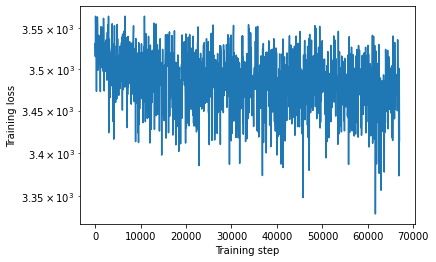

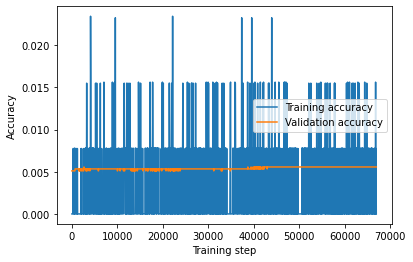

In [33]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did the more complex networks you built compare to the simple network we started with?
    - None of them really performed any better. The more complex networks took longer to train, and the deepest network failed to learn anything.
2. Which was more useful -- adding _depth_ to your network or adding width?
    - Adding _some_ depth is helpful, but too much can make training difficult. Adding too much width didn't help much.
3. Which optimizer performed best?
    - Adam performs best and has the smoothest convergence, though on the simpler networks SGD did surprisingly well.
4. What had the biggest effect on performance: depth, width, or optimizer?
    - The optimizer has the biggest effect.

#### Re-Cap
1. Power of PyTorch is to allow us to setup the neural networks using nn.Module

2. We can use the same neural network over and over with different data without having to re-write the code.